<a href="https://colab.research.google.com/github/leonardoLavagna/Drug-repurposing/blob/main/BI_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Set up

In [ ]:
# NEEDED FILES

"""
All the files are available at https://github.com/leonardoLavagna/Drug-repurposing
except for 2. which is available at https://downloads.thebiogrid.org/BioGRID and
3. which is available at https://www.disgenet.org/downloads.

1. auxiliary_functions.py
2. BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt
3. curated_gene_disease_associations.tsv
4. dgidb_final.tsv
5. DIaBLE.py
6. DIAMOnD.py
7. diff_res.txt
8. FinalAllSeeds.csv
9. First200AllSeeds.txt
"""

In [ ]:
# IMPORTANT FILES CREATED AND OFTEN USED

"""
1. Hypertensive disease_seed_gene.txt: seed genes for our disease of study
2. Hypertensive disease_splits.json: seed genes'splits for cross validation
3. PPI_Hypertensive.txt: protein-protien interaction
4. cross{i}.txt: training sets in cross validation
5. probeset{i}.txt: probe sets in cross validation
6. alg_name_results_tot.txt: results of each algorithm (DIAMOnD or DIaBLE)
7. ResDiffusionCross{}_t={}: results of diffusion algorithm
8. splits.json: seed gene's splits in json format
"""

In [ ]:
# GLOBAL VARIABLES NAMES

"""
CX: cytoscape type of network 
DGA: disease gene association
DN: disease network
G: disease Network large connected component
HSN: homo sapiens interactome
LCC: large connected component in HSN
seeds: seed gene' symbols
"""

In [ ]:
# REFERENCE CODE FOR DIAMOnD 

#!git clone https://github.com/dinaghiassian/DIAMOnD 

In [ ]:
# REFERENCE CODE FOR DIaBLE 
# Change the code in the DIAMOnD script as follows

"""
AFTER LINE 317 ADD

  candidates = set(cluster_nodes)
  universe = set()

  for _ in range(0, 2):
    for gene in candidates.copy():
      universe |= neighbors[gene]
    candidates = universe        
  
  N = len(universe)
  
"""

In [ ]:
# IN ORDER TO USE nx.to_scipy_sparse_matrix THE PROPER VERSION OF networkx IS NEEDED
# IF NEEDED UNINSTALL IT AND REINSTALL THE CORRECT VERSION
# Remark . Remember to restart the kernel to apply these changes

#%pip uninstall networkx
#%pip install networkx==2.3

In [ ]:
# INSTALL NON-STANDARD LIBRARIES
# See: https://github.com/GuyAllard/markov_clustering

#%pip install markov_clustering 

In [ ]:
# INSTALL NON-STANDARD LIBRARIES 
#See: https://ndex2.readthedocs.io/en/latest/createnicecx.html

#%pip install ndex2

In [ ]:
# MOUNT DRIVE
# Remark . Assign colab = True when using Google Colab
# Remark . While using Google colab remeber to collect all the needed files in
#          the folder BI-Data in your Google Drive.

import os
colab=True
if colab:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    os.chdir('/content/drive/MyDrive/BI-Data/')

In [ ]:
# DIRECTORY TREE
# Remark . Change according to your file system.
# Remark. This path should be the same used in the auxiliary_funtions module.
# Remark . When using Google Colab remember that the path has been changed to 
# /content/drive/MyDrive/BI-Data/ 

path = './'

In [ ]:
# IMPORT NEEDED LIBRARIES AND SELF DEFINED FUNCTIONS

import re
import csv
import random
import json
import ast
import sys
import statistics
import ndex2
import requests
import base64
import auxiliary_functions as AF
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import markov_clustering as mc
from tqdm import tqdm
from scipy.stats import hypergeom

# TASK 1 . PPI and GDA data gathering and interactome reconstruction

## Data gathering and interactome reconstruction

In [ ]:
# DATA GATHERING AND PROCESSING

HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")
DGA_all = pd.read_csv(path+'curated_gene_disease_associations.tsv',sep='\t')
DGA =  DGA_all[DGA_all['diseaseName'] == 'Hypertensive disease']
DGA = AF.DGA_processing(path+'curated_gene_disease_associations.tsv', 'Hypertensive disease')

Processing interactome...


<ipython-input-7-ea389ed6b4af>:3: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")


# Process completed.


In [ ]:
# CREATE INTERACTOME AND SPLITS
# Remark . If the file 'Hypertensive disease_splits' has not been created
#          uncomment the following line

DG_in_PPI,splits = AF.make_seeds_splits(DGA,HSN,'Hypertensive disease',path)
DG_in_PPI, splits = AF.import_seeds_split('Hypertensive disease')

Creating seed gene splits...
Number of genes in disease PPI:  290
# Process completed.
Importing seed genes...
# Process completed.


## Compute the disease LCC and its basic network measures

In [ ]:
# LCC OF HSN COMPUTATION

LCC = AF.extract_LCC_form_PPI(HSN)

Extracting LCC...
Nodes  19618 , Connections  665061
# Process completed.


Creating Disease LCC graph...
Nodes in disease LCC  232
# Process completed.


/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


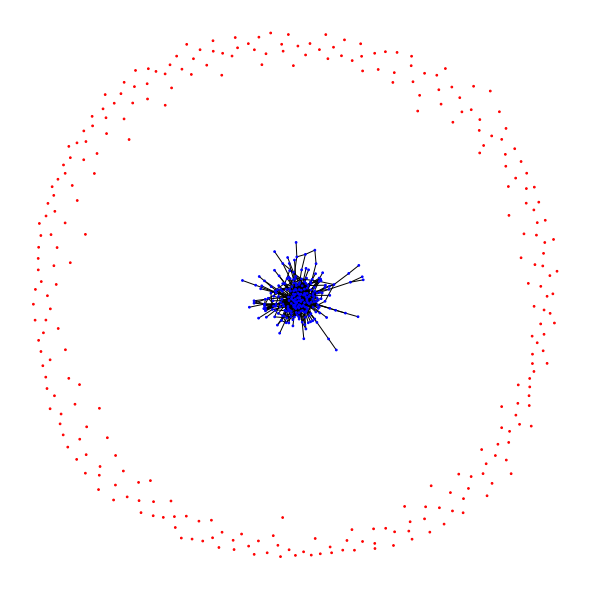

In [ ]:
# LCC OF DISEASE PLOT

DN = AF.make_disease_graph(HSN, DGA, DG_in_PPI)
AF.plot_LCC(DN, DG_in_PPI)

In [ ]:
# DISEASE NETWORK LCC

Gcc = sorted(nx.connected_components(DN), key=len, reverse=True)
G = DN.subgraph(Gcc[0])
n_nodes = G.number_of_nodes()

In [ ]:
# NETWORK MEASURES
# Remark . Execute only once. Moreover this cell takes a while to run...

nx.set_node_attributes(G, G.degree(), 'Node degree')  
nx.set_node_attributes(G, nx.betweenness_centrality(G), "Betweenness centrality")
nx.set_node_attributes(G, nx.eigenvector_centrality(G), "Eigenvector centrality")
nx.set_node_attributes(G, nx.closeness_centrality(G), "Closeness centrality")

local_measures = pd.DataFrame(index=G.nodes())
local_measures['Node degree'] = [d for n, d in G.degree()] 
local_measures['Betweenness centrality'] = pd.Series(nx.get_node_attributes(G, 'Betweenness centrality'))
local_measures['Eigenvector centrality'] = pd.Series(nx.get_node_attributes(G, 'Eigenvector centrality'))
local_measures['Closeness centrality'] = pd.Series(nx.get_node_attributes(G, 'Closeness centrality'))
local_measures['Betweenness/Degree Ratio'] = local_measures['Betweenness centrality']/local_measures['Node degree']
local_measures.index.name='Gene'

In [ ]:
# SAVE TABLE WITH NETWORK MEASURES IN FILE local_measures.csv
# Remark . Execute only once to create the file

local_measures.to_csv(path+'local_measures.csv', index = True, header = True)

In [ ]:
# CHECK

local_measures = pd.read_csv(path+'local_measures.csv', sep=',')
local_measures = local_measures.sort_values(by=['Betweenness/Degree Ratio'], ascending=False)
local_measures.head(50)

,Gene,Node degree,Betweenness centrality,Eigenvector centrality,Closeness centrality,Betweenness/Degree Ratio
215,5592,3,0.025880,0.018742,0.293147,0.008627
123,1813,5,0.034369,0.041870,0.336735,0.006874
198,4015,3,0.017315,0.009222,0.270175,0.005772
122,4881,3,0.017278,0.001563,0.227811,0.005759
104,3827,5,0.027271,0.019728,0.297297,0.005454
192,1956,48,0.249847,0.333165,0.456522,0.005205
191,4512,3,0.013786,0.006281,0.270809,0.004595
172,1401,2,0.009061,0.011981,0.281364,0.004530
148,857,30,0.134426,0.165287,0.412500,0.004481
214,2006,2,0.008658,0.000764,0.213296,0.004329


# TASK 2 . Putative disease genes identification algorithms

## Set up

In [ ]:
# STORE  THE INTERACTOME IN FILE PPI_Hypertensive.txt
# Remark . Execute only once to create the file

pairs_genes = list(LCC.edges)
textfile = open(path+"PPI_Hypertensive.txt", "w")
for gA, gB in tqdm(pairs_genes):
  textfile.write(str(gA) + ',' + str(gB) + '\n') 
textfile.close()

100%|██████████| 665061/665061 [00:00<00:00, 777482.28it/s]


In [ ]:
# LOAD DATA

# Dict with pair k,v where k is the index and v is the list of genes in the probe set
with open(path+'Hypertensive disease_splits.json') as f:
  dict_ = json.load(f)

# import seed genes
with open(path+'Hypertensive disease_seed_gene.txt') as f:
  data = f.read()
  seeds = ast.literal_eval(data)
  seeds = np.asarray(seeds)   

  with open(path+'all_seeds.txt','w') as f:
        for item in seeds:
            f.write("%s\n" % item)
  

In [ ]:
# CHECK

#dict_.items()

In [ ]:
# CHECK

#print(type(dict_))
#print(len(dict_["0"]))

In [ ]:
# CROSS VALIDATION SPLITS INTO FILES 
# Remark . Execute only once to create the files

for k,v in dict_.items():
    print(k,v)

    with open(path+'probeset{}.txt'.format(k),'w') as f:
        for item in v:
            f.write("%s," % item)   

    l=list(set(seeds).difference(set(v))) 
    # check
    # 58 is the probe set v
    # therefore 290-58 has to be the training set l
    print(len(l)==290-58)
 
    with open(path+'cross{}.txt'.format(k),'w') as f:
        for item in l:
            f.write("%s\n" % item)
    

0 ['ND1', 'TIMP1', 'APOA1', 'AGTR2', 'IFT27', 'WNK1', 'REN', 'HSD11B2', 'AQP1', 'SMAD4', 'COL4A3', 'CTGF', 'NME1', 'UCN', 'LDLRAP1', 'PLG', 'UCP2', 'PLAT', 'MMP9', 'KNG1', 'TRNV', 'CPOX', 'FGA', 'ACT', 'ALAD', 'NOS2', 'FXYD2', 'BBS9', 'NPTN', 'NCF1', 'ATP1A2', 'TGM2', 'NEDD4L', 'KLK1', 'STK39', 'ERCC4', 'PLIN1', 'BBS2', 'DUSP5', 'THPO', 'ABCB6', 'PPP1R3A', 'CALR', 'ICAM1', 'CLCNKA', 'MDH1', 'GCG', 'PTGS2', 'CELA2A', 'FOXF1', 'FN1', 'TNFRSF11B', 'FMO3', 'AOC1', 'GJA5', 'OLR1', 'SLC12A3', 'PDE8B']
True
1 ['ABCC1', 'PRKACA', 'JAK2', 'IGF1', 'KCNMB1', 'CD36', 'OXSR1', 'TRAF3IP1', 'CCL2', 'PTEN', 'BBS7', 'LMNA', 'WDPCP', 'COL3A1', 'CMA1', 'LEPR', 'TLR4', 'SLC37A4', 'NOS3', 'TRH', 'ITM2B', 'TNF', 'OFD1', 'COL4A4', 'COX3', 'ERCC6', 'CRP', 'UTS2', 'KCNJ5', 'MYH11', 'SMARCAL1', 'ND5', 'GP1BA', 'DRD2', 'NPPB', 'FOS', 'GSTT1', 'KCNJ1', 'GUCY1A3', 'FGFR2', 'CAV1', 'JUN', 'SOD1', 'MKKS', 'SMAD3', 'VCAM1', 'CYP11B1', 'ATP1A1', 'INS', 'IDUA', 'EDN1', 'TRIM32', 'SH2B3', 'GNRH1', 'AGTR1', 'ERCC8', 'AHR

## Evaluation of performances for DIAMOnD

In [ ]:
# DIAMOnD ALGORITHM EVALUATION
# Remark . This cell takes some time to run...
# If neded, repeat for different values of tot

alg_name = "DIAMOnD"
tot = 50

recall= []
precision = []             
F1_score = []

!python3  DIAMOnD.py  PPI_Hypertensive.txt  cross0.txt  200 "res0.txt"
m = AF.evaluation(tot, 58, alg_name,0)
  
recall.append(m['recall'])
precision.append(m['precision'])
F1_score.append(m['F1 Score'])


 results have been saved to 'res0.txt' 

set()


In [ ]:
# CODE TO EVALUATE DIAMOnD WITH DIFFERENT VALUES OF tot
# Remark . This code can also be used for DIaBLE with minimal adjustments

"""
for k in [50,25,15,1]:
  recall= []
  precision = []             
  F1_score = []

  tot = k

  !python3  DIAMOnD.py  PPI_Hypertensive.txt  cross0.txt  200 "res0.txt"
  m = AF.evaluation(tot, 58, alg_name,0)
  
  recall.append(m['recall'])
  precision.append(m['precision'])
  F1_score.append(m['F1 Score'])

  !python3  DIAMOnD.py  PPI_Hypertensive.txt  cross1.txt  200 "res1.txt"
  m = AF.evaluation(tot, 58, alg_name,1)
  recall.append(m['recall'])
  precision.append(m['precision'])
  F1_score.append(m['F1 Score'])

  !python3  DIAMOnD.py  PPI_Hypertensive.txt  cross2.txt  200 "res2.txt"
  m = AF.evaluation(tot, 58, alg_name,2)  
  recall.append(m['recall'])
  precision.append(m['precision'])
  F1_score.append(m['F1 Score'])

  !python3  DIAMOnD.py  PPI_Hypertensive.txt  cross3.txt  200 "res3.txt"
  m = AF.evaluation(tot, 58, alg_name,3)  
  recall.append(m['recall'])
  precision.append(m['precision'])
  F1_score.append(m['F1 Score'])

  !python3  DIAMOnD.py  PPI_Hypertensive.txt  cross4.txt  200 "res4.txt"
  m = AF.evaluation(tot, 58, alg_name,4)  
  recall.append(m['recall'])
  precision.append(m['precision'])
  F1_score.append(m['F1 Score'])
  
  # Metrics
  #print(recall)
  recall_value = statistics.mean(recall)
  precision_value= statistics.mean(precision)
  F1_score_value = statistics.mean(F1_score)

  print(recall_value)
  print(precision_value)
  print(F1_score_value)
"""

0
0
0


## Evaluation of performances for DIaBLE

In [ ]:
# DIaBLE ALGORITHM EVALUATION
# Remark . This cell takes some time to run...
# If neded, repeat for different values of tot

alg_name = "DIaBLE"
tot = 50

recall= []
precision = []             
F1_score = []

!python3  DIAMOnD.py  PPI_Hypertensive.txt  cross0.txt  200 "res1.txt"
m = AF.evaluation(tot, 58, alg_name,1)
  
recall.append(m['recall'])
precision.append(m['precision'])
F1_score.append(m['F1 Score'])

In [ ]:
# METRICS

#print(recall)
recall_value = statistics.mean(recall)
precision_value= statistics.mean(precision)
F1_score_value = statistics.mean(F1_score)

print(recall_value)
print(precision_value)
print(F1_score_value)

## Evaluation of performances for Diffusion

### Diffusion algorithm

In [ ]:
# CREATE CX OBJECT FROM NETWORK

CX = ndex2.create_nice_cx_from_networkx(LCC).to_cx()

In [ ]:
#nice_cx_net = ndex2.create_nice_cx_from_server(server='http://public.ndexbio.org',
#                                               uuid='c0e70804-d848-11e6-86b1-0ac135e8bacf')

nice_cx_net = ndex2.create_nice_cx_from_raw_cx(CX)

In [ ]:
# CHECK

print(nice_cx_net)

In [ ]:
# CHECK
# Remark . Remove break to have the complete (very long) list

for nodeid, nodeobj in nice_cx_net.get_nodes():
    nice_cx_net.remove_node_attribute(node=nodeid, attribute_name='diffusion_input')
    nice_cx_net.set_node_attribute(type='double', node=nodeid, attribute_name='diffusion_input', values='1.0')
    print(nice_cx_net.get_node_attribute(nodeid,'diffusion_input'))
    break

In [ ]:
# CALL THE DIFFUSION SERVICE
# Remark . This cell takes some time to run...

url = 'http://v3.heat-diffusion.cytoscape.io'
payload = nice_cx_net.to_cx()
for p in payload:
    k = list(p.keys())[0]
    if 'Attributes' in k:
        for i in range(len(p[k])):
            p[k][i]['v'] = str(p[k][i]['v'])
response = requests.post(url, json=payload)

In [ ]:
# GET DIFFUSION RESULTS
# Remark . The data dictionary in the json response response.json()['data'] is a dictionary 
#          that contains CX formatted data with results of diffussion.

for aspect in response.json()['data']:
    if 'nodeAttributes' not in aspect:
        continue
    for n_attr in aspect['nodeAttributes']:
        if n_attr['n'] == 'diffusion_output_rank' or n_attr['n'] == 'diffusion_output_heat':
            if n_attr['d'] == 'float':
                n_type = 'double'
            else:
                n_type = n_attr['d']
            nice_cx_net.add_node_attribute(property_of=int(n_attr['po']),
                                 name=n_attr['n'],
                                 values=n_attr['v'],
                                 type=n_type)

In [ ]:
# OUTPUT BEST RESULTS FROM DIFFUSION

nos = []
for node_id, node in nice_cx_net.get_nodes():
    rank = nice_cx_net.get_node_attribute_value(node_id, 'diffusion_output_rank')
    if int(rank) < 10:
        node['diffusion_output_rank'] = rank
        heat = nice_cx_net.get_node_attribute_value(node_id, 'diffusion_output_heat')
        node['diffusion_output_heat'] = float(heat)
        nos.append(node)

# sort the result
nos = sorted(nos, key=lambda k: k['diffusion_output_rank'])       
nos

In [ ]:
# THE RESULTS HAVE BEEN SAVED IN THE FOLLOWING txt FILE
# Remark . The file diff_res.txt should be present in the working directory
#          and has been created separately.

data=pd.read_csv('diff_res.txt'.format(i),sep='\t')

In [ ]:
# SORTING

data=data.sort_values(by='diffusion_output_heat',ascending=False)
print(data)

### Evaluation

In [ ]:
# INITIALIZATION BEFORE DIFFUSION EVALUATION

Pre_con_diffusion_results={}
Pre_con_diffusion_results['precision']={}
Pre_con_diffusion_results['recall']={}
Pre_con_diffusion_results['f1_score']={}

for i in Pre_con_diffusion_results.keys():
    Pre_con_diffusion_results[i]['std_valid']={}
    Pre_con_diffusion_results[i]['ext_valid']={}


In [ ]:
# AUXILIARY FUNCTION (to check)

def D_evaluation(top_n, disease_dict, DGA=DGA_all, data=data):
    
    recall_=[]
    f1_score_=[]
    precision_=[]

    recall_all=[]
    f1_score_all=[]
    precision_all=[]
    
    all_DGA=set(DGA[DGA['diseaseName'] == 'Hypertensive disease'].geneId)

    for i in range(5):
        ids=DGA[DGA.geneSymbol.isin(dict_[str(i)])].geneId.tolist()
        probe_length=len(ids)
        new=data[0:top_n]

        num=len(set(new).intersection(ids))
        pre=num/top_n
        precision_.append(pre)
        rec=num/len(ids)
        recall_.append(rec)
        f1=2*(pre*rec)/(pre+rec+0.0001)
        f1_score_.append(f1)

        TP=set(new).intersection(ids)
        FP=[x for x in new if x not in ids]
        FP=FP[:len(ids)]

        num=len(set(FP).intersection(all_DGA))
        pre=num/len(FP)
        rec=num/len(all_DGA)
        f1=2*(pre*rec)/(pre+rec+0.0001)
        precision_all.append(pre)
        recall_all.append(rec)
        f1_score_all.append(f1)
    
    disease_dict['precision']['std_valid'][str(top_n)]={}
    disease_dict['precision']['std_valid'][str(top_n)]['mean']=np.average(precision_)
    disease_dict['precision']['std_valid'][str(top_n)]['sd']=np.std(precision_)

    disease_dict['recall']['std_valid'][str(top_n)]={}
    disease_dict['recall']['std_valid'][str(top_n)]['mean']=np.average(recall_)
    disease_dict['recall']['std_valid'][str(top_n)]['sd']=np.std(recall_)

    disease_dict['f1_score']['std_valid'][str(top_n)]={}
    disease_dict['f1_score']['std_valid'][str(top_n)]['mean']=np.average(f1_score_)
    disease_dict['f1_score']['std_valid'][str(top_n)]['sd']=np.std(f1_score_)

    disease_dict['precision']['ext_valid'][str(top_n)]={}
    disease_dict['precision']['ext_valid'][str(top_n)]['mean']=np.average(precision_all)
    disease_dict['precision']['ext_valid'][str(top_n)]['sd']=np.std(precision_all)

    disease_dict['recall']['ext_valid'][str(top_n)]={}
    disease_dict['recall']['ext_valid'][str(top_n)]['mean']=np.average(recall_all)
    disease_dict['recall']['ext_valid'][str(top_n)]['sd']=np.std(recall_all)

    disease_dict['f1_score']['ext_valid'][str(top_n)]={}
    disease_dict['f1_score']['ext_valid'][str(top_n)]['mean']=np.average(f1_score_all)
    disease_dict['f1_score']['ext_valid'][str(top_n)]['sd']=np.std(f1_score_all)



In [ ]:
# DIFFUSION ALGORITHM EVALUATION 

for size in [100,250,500,1000]:
    D_evaluation(size,Pre_con_diffusion_results)

In [ ]:
# DISPLAY THE RESULTS

AF.display_dict(Pre_con_diffusion_results) 

### Diffusion algorithm with Cytoscape

In [ ]:
# DIFFUSION ALGORITHM EVALUATION

cval = 58

for t in [0.01,0.002,0.005]:
    print("t is ",t)
    for at in [50,25,15,1]:
      print("metrics at",at)
      recall= []
      precision = []             
      F1_score = []

      top_n = at
      recall= []
      precision = []             
      F1_score = []
      
      m = AF.evaluationDiffusion(top_n, cval, t,0,path)
      recall.append(m['recall'])
      precision.append(m['precision'])
      F1_score.append(m['F1 Score'])

      m = AF.evaluationDiffusion(top_n, cval, t,1,path)
     
      recall.append(m['recall'])
      precision.append(m['precision'])
      F1_score.append(m['F1 Score'])

      m = AF.evaluationDiffusion(top_n, cval, t,2,path)
      
      recall.append(m['recall'])
      precision.append(m['precision'])
      F1_score.append(m['F1 Score'])

      m = AF.evaluationDiffusion(top_n, cval, t,3,path)
      
      recall.append(m['recall'])
      precision.append(m['precision'])
      F1_score.append(m['F1 Score'])

      m = AF.evaluationDiffusion(top_n, cval, t,4,path)
      
      recall.append(m['recall'])
      precision.append(m['precision'])
      F1_score.append(m['F1 Score'])

      recall_value = statistics.mean(recall)
      precision_value= statistics.mean(precision)
      F1_score_value = statistics.mean(F1_score)

      print(recall_value)
      print(precision_value)
      print(F1_score_value)

t is  0.01
metrics at 50
0
0
0
metrics at 25
0
0
0
metrics at 15
0
0
0
metrics at 1
0
0.2
0
t is  0.002
metrics at 50
0
0
0
metrics at 25
0
0
0
metrics at 15
0
0
0
metrics at 1
0
0
0
t is  0.005
metrics at 50
0
0
0
metrics at 25
0
0
0
metrics at 15
0
0
0
metrics at 1
0
0.4
0


In [ ]:
cv = pd.read_csv(path + 'FinalAllSeeds.csv')
data=cv.sort_values(by='diffusion_output_heat',ascending=False)['name']
top = set(data[0:200])
with open(path+'First200AllSeeds.txt','w') as f:
  for item in top:
      f.write("%s\n" % item)

# TASK 3 . Putative disease genes identification

## Set up

## MCL

In [ ]:
G = LCC

In [ ]:
# CLUSTERS
# Remark . This cell takes a while to run...

result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))           
clusters = mc.get_clusters(result) 

/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


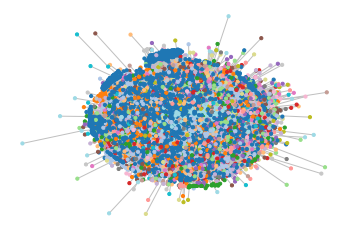

In [ ]:
# PLOT
# Remark . This cell takes a while to run...

mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")

In [ ]:
# CLUSTERING WITH DIFFERENT INFLATION VALUES AND MODULARITY COMPUTATION
# Remark . This cell takes a while to run...
# Remark . A standard RAM cannot usually carry out the computation. Do not execute
#          if the RAM is insufficient (~32 GB should be enough)

matrix = nx.to_scipy_sparse_matrix(G)

for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

In [ ]:
# KEEP CLUSTERS WITH AT LEAST 10 GENES

big_clusters = []
for module in clusters:
    if len(module) >= 10:
        big_clusters.append(module)
print(len(clusters), len(big_clusters))

4490 203


In [ ]:
# DICTIONARY WITH MAPPING Ids-->Names

val = range(LCC.number_of_nodes())
names = list(LCC.nodes())
dic = dict(zip(val, names))

In [ ]:
# RUN HYPERGEOMETRIC TEST TO FIND MODULES WITH STATISTICALLY OVER-REPRESENTED GENES

putative_desease_modules = []
M = G.number_of_nodes()  
n = len(seeds) 
p_val_list = []
for module in big_clusters:
    # number of draws (number of genes in the given cluster)
    N = len(module) 
    x = len(set(seeds).intersection(set(dic[g] for g in module)))
    p_val = hypergeom.sf(x-1, M, n, N)
    if p_val < 0.05:
        putative_desease_modules.append(module)
        p_val_list.append(p_val)

In [ ]:
# CHECK

for i in range(len(putative_desease_modules)):
    print("Desease putative module ",i, ": ", *[dic[g] for g in putative_desease_modules[i]])

Desease putative module  0 :  ACVR1 UGCG BMPR1A ACVR2A BMPR2 SMAD6 BMP2 BMPR1B GDF6 ACVR2B AXL INHBA IFNGR1 ACVRL1 IGSF1 BAMBI NODAL RGMB BMP6 PLEKHH3
Desease putative module  1 :  ITPR1 BOK TRPC6 TRPC2 TRPC1 TRPC5 TRPC4 SSFA2 TRPC3 ITPR3 TRPC7 ITPR2
Desease putative module  2 :  NR3C1 RXRA THRB ROBO4 IL1RAPL1 ONECUT1 TNC ABCA4 NR3C2 ZXDC NR1I3 MEPE FAM160B2 SMARCAL1 THAP2 ASXL3 IL22RA2 RAD51AP2 CDH17 SMOC2 ZNF536 STK31 CDY1 ZFP82 OR2T1 ARID3C CNGB1 MC3R ZNF823 PDE6A DNAH7 TBX4 PLEKHH1 BTBD11 HIST2H2BD LOC102724159 LMOD2 LRRC37A3 DNAH12 FER1L6 ZNF442 TRIM64C WDR64 PIRT ATP13A4 WDR17 RRP7B LINC01549 SLC25A34 LINC00299 TMEM156 OR52P1P
Desease putative module  3 :  IFT88 IFT27 IFT172 IFT57 TRAF3IP1 UBXN10 IFT81 IFT46 IFT22 CCDC151 IFT20 TTC26 IFT80 IFT74 TTC30A TTC30B IFT52 HSPB11 TFPI2 COX4I1P1
Desease putative module  4 :  APOA1 PIKFYVE APOH GALNT4 GC APOL1 APOF APOA2 HP CP ABCA13 SERPINA1 LCAT ORM1 HPX GOT1L1 APOA4 HPR SMPDL3A ERVK-10
Desease putative module  5 :  HECW1 NEDD4 WWP1 EPHA

In [ ]:
# DATAFRAME WITH PUTATIVE DISEASE MODULES

header = ['ModuleID', "Number of seed genes/module", "Module size", "Seed genes", "All genes", "p-value"]
df_putative_desease_modules = pd.DataFrame(columns=header)
for i in range(len(putative_desease_modules)):
    seeds = set(seeds).intersection(set(dic[g] for g in putative_desease_modules[i]))
    values = [i, len(seeds), len(putative_desease_modules[i]), seeds, [dic[g] for g in putative_desease_modules[i]],p_val_list[i]]
    df = pd.DataFrame( [values], columns = header)
    df_putative_desease_modules = df_putative_desease_modules.append(df, ignore_index=True)

In [ ]:
# CHECK

df_putative_desease_modules

,ModuleID,Number of seed genes/module,Module size,Seed genes,All genes,p-value
0,0,2,20,"{ACVRL1, BMPR2}","[ACVR1, UGCG, BMPR1A, ACVR2A, BMPR2, SMAD6, BM...",0.034727
1,1,0,12,{},"[ITPR1, BOK, TRPC6, TRPC2, TRPC1, TRPC5, TRPC4...",0.013034
2,2,0,52,{},"[NR3C1, RXRA, THRB, ROBO4, IL1RAPL1, ONECUT1, ...",0.041543
3,3,0,20,{},"[IFT88, IFT27, IFT172, IFT57, TRAF3IP1, UBXN10...",0.003025
4,4,0,20,{},"[APOA1, PIKFYVE, APOH, GALNT4, GC, APOL1, APOF...",0.034727
5,5,0,20,{},"[HECW1, NEDD4, WWP1, EPHA5, ITCH, SLC38A3, SCN...",0.034727
6,6,0,35,{},"[CCL5, CXCL1, CCL2, CXCL8, CXCR3, CCL7, CXCL13...",0.014759
7,7,0,21,{},"[CUL3, KCTD11, ENC1, KBTBD13, WNK4, TNFAIP1, O...",0.038015
8,8,0,11,{},"[CAND2, ATP2B4, ATP2B2, HMGB3, SLC45A2, ATP2B1...",0.010968


In [ ]:
# SAVE DATAFRAME TO csv FILE

df_putative_desease_modules.to_csv(path+'df_putative_desease_modules.csv', index = True, header = True)

# Task 4 . Best algorithm choice and putative disease gene identification

...

# Task 5 . Drug Repurposing

Taken the 20 seed genes with highest `diffusion_output_heat` we leveraged the dgidb database (see, https://www.dgidb.org) and we selected the best six drugs w.r.t. its association with the previous 20 genes. 

In [ ]:
df = pd.read_csv(path+'dgidb_final.tsv',sep = '\t')

In [ ]:
AF.find_best_drugs(df)

['TAMOXIFEN',
 'IMIPRAMINE',
 'AMOXAPINE',
 'DESIPRAMINE',
 'PROTRIPTYLINE',
 'PSEUDOEPHEDRINE']